In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup as bs
import requests

In [4]:
import warnings
warnings.filterwarnings('ignore')

# SRAPE DATA FROM https://ss.ge/ka/udzravi-qoneba 

In [3]:
df=pd.DataFrame()

for j in range(1,2):
    main_url=f'https://ss.ge/ka/udzravi-qoneba/l/bina/iyideba?Page={j}&amp;RealEstateTypeId=5&amp;RealEstateDealTypeId=4&amp;MunicipalityId=95&amp;CityIdList=95&amp;PriceType=false&amp;CurrencyId=1'
    page=requests.get(main_url,verify=False).content   #,verify=False
    soup=bs(page,'html.parser')
    
    items=soup.select('div[id="main-body"] div[class="MobileArticleLayout"]')
    data_dict=[]

    for i in items:
        price=i.select_one('div[class="latest_desc"] div[class="f-between mobile_top_spec"] div[class="latest_price"]')
        area=i.select_one('div[class="latest_desc"] div[class="latest_flat_km"]')
        condition=i.select_one('div[class="latest_desc"] div[class="latest_flat_type"]')
        stair=i.select_one('div[class="latest_desc"] div[class="latest_stair_count"]')
        location=i.select_one('div[class="latest_desc"] div[class="StreeTaddressList"]')
        
        price=price.text.strip().replace(' ','') if price else None
        area=area.text.strip().replace(' ','') if area else None
        condition=condition.text.strip().replace(' ','') if condition else None
        stair=stair.text.strip().replace(' ','') if stair else None
        location=location.text.strip().replace(' ','') if location else None
        
        href=i.select_one('a:nth-child(1)')['href']
        new_url=f'https://ss.ge{href}'
        new_page=requests.get(new_url,verify=False).content
        new_soup=bs(new_page,'html.parser')
        room=new_soup.select_one('div[class="article_item_parameters"] div[class="ParamsDetTop"] div[class="EAchParamsBlocks RoomsParBlock"] div[class="ParamsHdBlk"]')
        status=new_soup.select_one('div[class="ParamsbotProj"] div:contains("სტატუსი") span[class="PRojeachBlack"]')
        project=new_soup.select_one('div[class="ParamsbotProj"] div:contains("პროექტი") span[class="PRojeachBlack"]')
        balcony=new_soup.select_one('div[class="ParamsbotProj"] div:contains("აივანი/ლოჯია") span[class="PRojeachBlack"]')
        bathroom=new_soup.select_one('div[class="ParamsbotProj"] div:contains("სველი წერტილი") span[class="PRojeachBlack"]')
        room=room.text.strip().replace(' ','') if room else None
        status=status.text.strip().replace(' ','') if status else None
        project=project.text.strip().replace(' ','') if project else None
        balcony=balcony.text.strip().replace(' ','') if balcony else None
        bathroom=bathroom.text.strip().replace(' ','') if bathroom else None

        data_dict.append({'Price':price,'Area':area,'Condition':condition,'Stair':stair,'Location':location,'Rooms':room,'Status':status,'Project':project,'Balcony':balcony,'Bathroom':bathroom})
    page_df=pd.DataFrame(data_dict)
    print(f'{j}/100 pages Downloaded')
    df=pd.concat([df,page_df],ignore_index=True)

1/100 pages Downloaded


In [5]:
# df.to_csv('ss.ge.csv')  # Already scraped

In [6]:
df=pd.read_csv('ss.ge.csv')
df=df.drop(['Unnamed: 0','Status'],axis=1)  #drop unwanted columns

# PROCESS DATA 

In [7]:
ndf=df.copy()

In [8]:
ndf

,Price,Area,Condition,Stair,Location,Rooms,Project,Balcony,Bathroom
0,110000U,37\r\nm²,ახალიაშენებული,8\r\nსართ.,ირინაშტენბერგისქ.,1.0,არასტანდარტული,1,1
1,229000U,186\r\nm²,ახალიაშენებული,4\r\nსართ.,აღმაშენებლისხეივანი(დიღმისმასივი),5.0,არასტანდარტული,1,2
2,318000U,60\r\nm²,ახალიაშენებული,2\r\nსართ.,მცხეთისქ.,3.0,არასტანდარტული,1,2
3,239000U,73\r\nm²,ახალიაშენებული,5\r\nსართ.,ბოჭორიშვილისქ.,3.0,NaN,1,2
4,170000U,90\r\nm²,ახალიაშენებული,5\r\nსართ.,ფატმანისქ.,4.0,NaN,1,2
...,...,...,...,...,...,...,...,...,...
1975,შეთანხმებით,40\r\nm²,ახალიაშენებული,16\r\nსართ.,ჩარგლისქ.(თემქა),2.0,არასტანდარტული,1,2
1976,30200U,100\r\nm²,NaN,5\r\nსართ.,NaN,4.0,არასტანდარტული,NaN,NaN
1977,119000U,52\r\nm²,ძველიაშენებული,6\r\nსართ.,Iმიკრორაიონი-ვარკეთილი,2.0,მოსკოვის,1,NaN
1978,112000U,37\r\nm²,ახალიაშენებული,7\r\nსართ.,შ.ნადირაშვილისქ.,2.0,არასტანდარტული,1,1


In [9]:
for col in ndf.columns:
    ndf[col]=ndf[col].replace({'\r\n':'','სართ.':'','m²':'','U':'','შეთანხმებით':np.NaN,'3,5,7,9':np.NaN,'არაქვს':0,'\n\n\nშეღავათიუკრაინელიმოქალაქეებისთვის':''},regex=True)
    
ndf['Bathroom']=ndf['Bathroom'].replace('5+',5)

In [10]:
#ndf=ndf.apply(pd.to_numeric,errors='ignore')
for col in ndf.columns:
    ndf[col]=pd.to_numeric(ndf[col],errors='ignore')

In [11]:
ndf.head()

,Price,Area,Condition,Stair,Location,Rooms,Project,Balcony,Bathroom
0,110000.0,37.0,ახალიაშენებული,8.0,ირინაშტენბერგისქ.,1.0,არასტანდარტული,1.0,1.0
1,229000.0,186.0,ახალიაშენებული,4.0,აღმაშენებლისხეივანი(დიღმისმასივი),5.0,არასტანდარტული,1.0,2.0
2,318000.0,60.0,ახალიაშენებული,2.0,მცხეთისქ.,3.0,არასტანდარტული,1.0,2.0
3,239000.0,73.0,ახალიაშენებული,5.0,ბოჭორიშვილისქ.,3.0,NaN,1.0,2.0
4,170000.0,90.0,ახალიაშენებული,5.0,ფატმანისქ.,4.0,NaN,1.0,2.0


In [12]:
ndf.isna().sum()

Price        109
Area           0
Condition     21
Stair          2
Location     107
Rooms          1
Project      145
Balcony      456
Bathroom     317
dtype: int64

In [13]:
ndf[ndf.isna().any(axis=1)]

,Price,Area,Condition,Stair,Location,Rooms,Project,Balcony,Bathroom
3,239000.0,73.00,ახალიაშენებული,5.0,ბოჭორიშვილისქ.,3.0,NaN,1.0,2.0
4,170000.0,90.00,ახალიაშენებული,5.0,ფატმანისქ.,4.0,NaN,1.0,2.0
5,87700.0,42.00,ახალიაშენებული,5.0,ა.წერეთლისგამზ.,2.0,არასტანდარტული,NaN,1.0
9,83600.0,40.22,ახალიაშენებული,5.0,ა.წერეთლისგამზ.,2.0,არასტანდარტული,NaN,1.0
11,507000.0,131.00,ახალიაშენებული,8.0,ანაპის414-ედივიზიისქ.,4.0,NaN,3.0,2.0
...,...,...,...,...,...,...,...,...,...
1950,343000.0,90.00,ძველიაშენებული,4.0,ლარსისქ.,4.0,ქალაქური,1.0,NaN
1954,165000.0,60.00,ძველიაშენებული,7.0,ნუცუბიძისIIIპლატო,3.0,მოსკოვის,NaN,2.0
1975,NaN,40.00,ახალიაშენებული,16.0,ჩარგლისქ.(თემქა),2.0,არასტანდარტული,1.0,2.0
1976,30200.0,100.00,NaN,5.0,NaN,4.0,არასტანდარტული,NaN,NaN


In [14]:
ndf['Condition'].fillna('ახალიაშენებული',inplace=True)
ndf['Balcony'].fillna(1,inplace=True)
ndf['Bathroom'].fillna(1,inplace=True)
ndf.query('Project.isna() and (Condition=="ახალიაშენებული" or Condition=="მშენებარე")')['Project'].fillna('არასტანდარტული',inplace=True)

ndf.isna().sum()

Price        109
Area           0
Condition      0
Stair          2
Location     107
Rooms          1
Project      145
Balcony        0
Bathroom       0
dtype: int64

In [15]:
ndf=ndf.dropna()

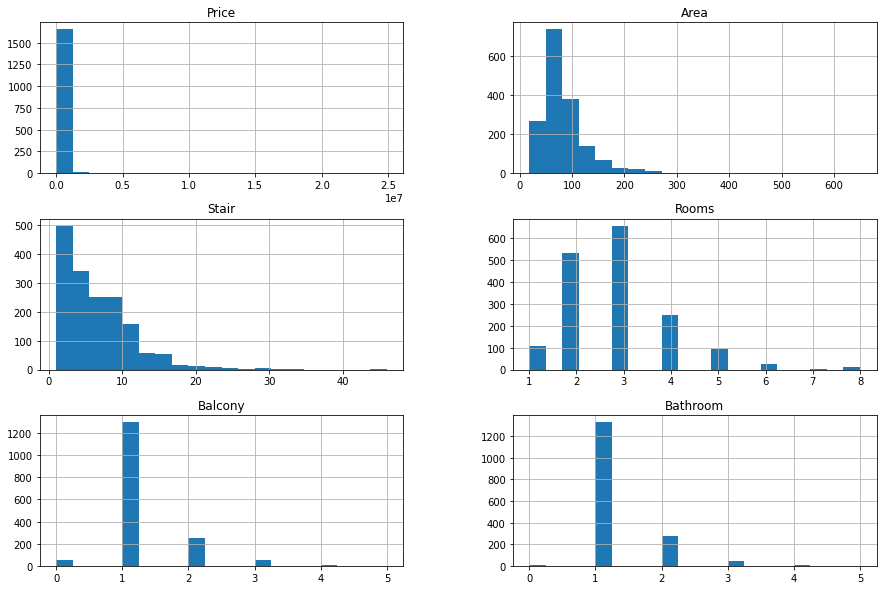

In [16]:
ndf.hist(figsize=(15,10),bins=20)
plt.show()

In [17]:
#ndf['m2price']=ndf['Price']/ndf['Area']

In [18]:
ndf=ndf.query('5000<Price<200000 and 15<Area<300 and 0<Stair<30 and 0<Rooms and 0<Bathroom')  #REMOVING OUTLIERS

In [19]:
ndf.corr()['Price'].sort_values(ascending=False)

Price       1.000000
Area        0.614246
Rooms       0.534447
Balcony     0.204665
Stair       0.148625
Bathroom    0.071548
Name: Price, dtype: float64

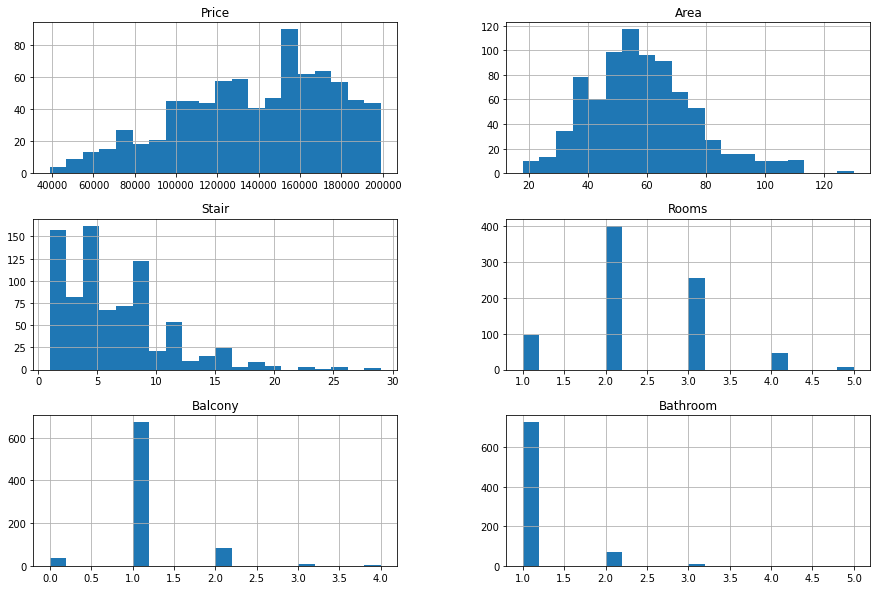

In [20]:
ndf.hist(figsize=(15,10),bins=20)
plt.show()

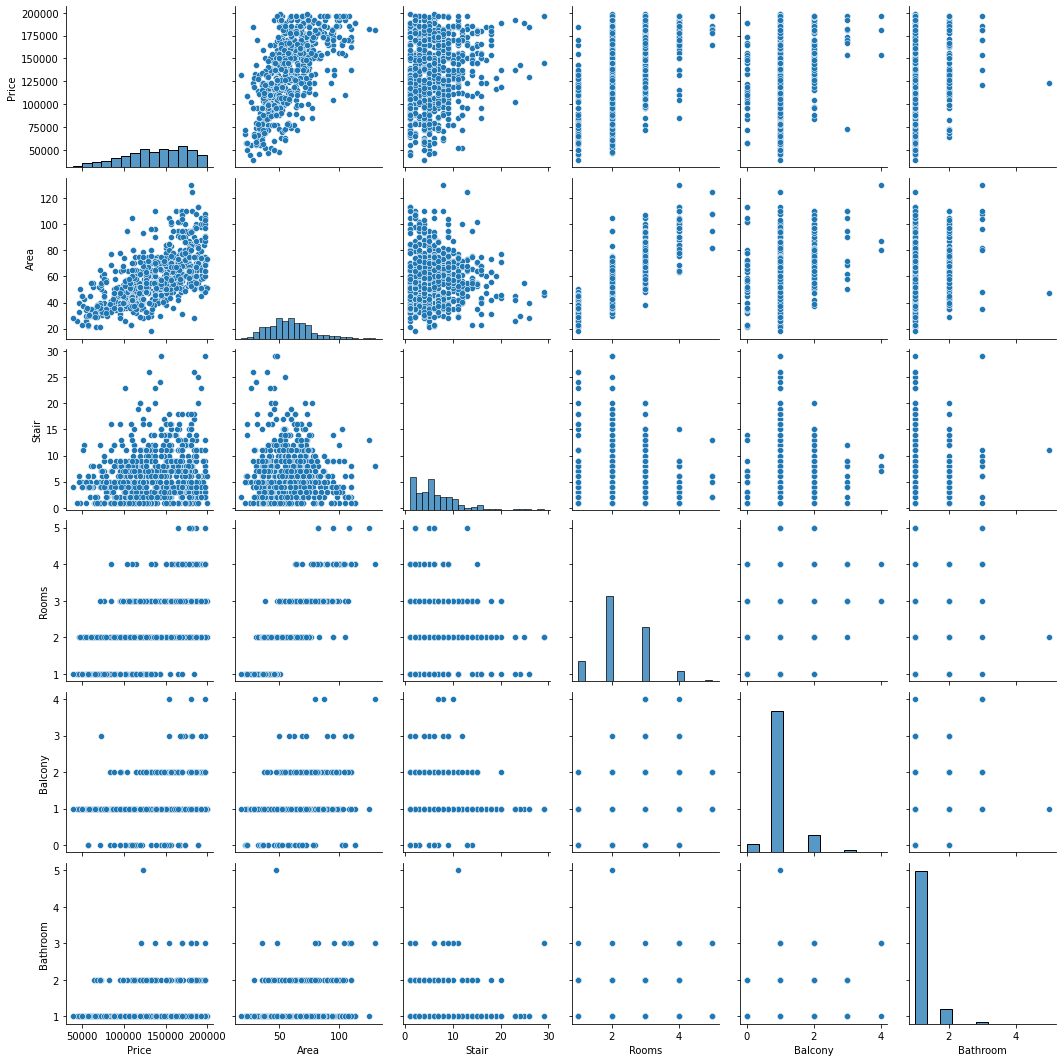

In [21]:
sns.pairplot(ndf)

In [22]:
for col in ndf.select_dtypes('object').columns:
    dummies=pd.get_dummies(df[col],prefix=col,dummy_na=False)
    ndf=ndf.drop(col,axis=1)
    ndf=ndf.merge(dummies,left_index=True,right_index=True)

In [23]:
X=ndf.drop('Price',axis=1)
y=ndf['Price']

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2)

In [26]:
from xgboost import XGBRegressor

In [27]:
model_xgbr=XGBRegressor()

In [28]:
model_xgbr.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [29]:
xtest_predictions=model_xgbr.predict(xtest)

In [30]:
from sklearn import metrics

In [31]:
mae=metrics.mean_absolute_error(xtest_predictions,ytest)
rmse=metrics.mean_squared_error(xtest_predictions,ytest,squared=False)
r2=metrics.r2_score(xtest_predictions,ytest)

In [32]:
print(f'MAE: {mae}, RMSE: {rmse}, R2: {r2}')

MAE: 14996.608627507716, RMSE: 20254.660721095253, R2: 0.5525304093591286


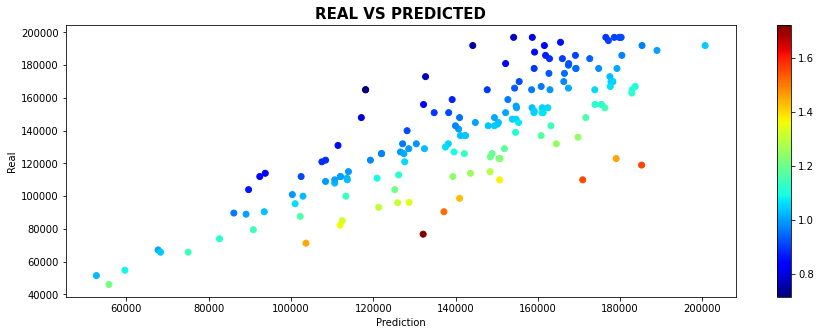

In [33]:
plt.figure(figsize=(15,5))
plt.scatter(xtest_predictions,ytest,c=xtest_predictions/ytest,cmap='jet')
plt.colorbar()
plt.title('REAL VS PREDICTED',fontweight='bold',size=15)
plt.xlabel('Prediction')
plt.ylabel('Real')
plt.show()